In [1]:
# Adapted from https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
# for kaggle satellite image classification dataset https://www.kaggle.com/mahmoudreda55/satellite-image-classification
# and then basic active learning was applied.

from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from pytorch_finetuning_utils import train_model, train_model_given_numpy_arrays, initialize_model
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
import sys
sys.path.append("..")
from test_framework.model_interface import ModelInterface
from test_framework.tester import Tester
from utils.data_utils import get_kaggle_satellite_image_classification_dataset_as_numpy_arrays
import categorical_query_functions

PyTorch Version:  1.10.0
Torchvision Version:  0.11.1


# parameters

In [2]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "../data/kaggle_satellite_image_classification"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet]
model_name = "squeezenet"

# Number of classes in the dataset
num_classes = 4

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 3#15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

# Use ~1/10 of the dataset
small_dataset = True

# parameters specific to active learning
active_learning_batch_size = 16
initial_train_data_fraction = 0.05
# QUERY_FUNCTION = categorical_query_functions.MIN_MAX
QUERY_FUNCTION = categorical_query_functions.MIN_MARGIN
# QUERY_FUNCTION = categorical_query_functions.MAX_ENTROPY

# Flag for whether to print train loss and accuracy after each epoch.
train_verbose = True

# Load data

In [3]:
x_data,y_data = get_kaggle_satellite_image_classification_dataset_as_numpy_arrays()
order = np.random.permutation(len(x_data))
x_data, y_data = x_data[order], y_data[order]

# Initialize model

In [4]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Conv2d(512, 4, kernel_size=(1, 1), stride=(1, 1))
  (2): ReLU(inplace=True)
  (3): AdaptiveAvgPool2d(output_size=(1, 1))
)


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
class ActiveLearningModel(ModelInterface):
    def __init__(self,model,name="no name provided",details="no details provided"):
        model.to(device)
        self.model = model
        self._name = name
        self._details = details
        # Gather the parameters to be optimized/updated in this run. If we are
        #  finetuning we will be updating all parameters. However, if we are
        #  doing feature extract method, we will only update the parameters
        #  that we have just initialized, i.e. the parameters with requires_grad
        #  is True.
        params_to_update = model.parameters()
        verbose = False
        if verbose:
            print("Params to learn:")
        if feature_extract:
            params_to_update = []
            for name,param in model.named_parameters():
                if param.requires_grad == True:
                    params_to_update.append(param)
                    if verbose:
                        print("\t",name)
        elif verbose:
            for name,param in model.named_parameters():
                if param.requires_grad == True:
                    print("\t",name)

        # Observe that all parameters are being optimized
        optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
        self._optimizer = optimizer_ft
        
        # store criterion
        self._criterion = nn.CrossEntropyLoss()

    def name(self) -> str:
        return self._name
    def details(self) -> str:
        return self._details
    def train(self, train_x:np.ndarray, train_y:np.ndarray) -> None:
        self.model = train_model_given_numpy_arrays(self.model, train_x, train_y, self._criterion, self._optimizer, num_epochs, batch_size, verbose=train_verbose)
    def predict(self, test_x:np.ndarray):
        self.model.eval()
        x_tensor = torch.tensor(test_x)
        dataset = TensorDataset(x_tensor)
        dataloader = DataLoader(dataset,batch_size=batch_size,num_workers=0,shuffle=True)
        preds_list = []
        for (inputs,) in dataloader:
            inputs = inputs.to(device)
            preds_list.append(self.model(inputs).cpu().detach().numpy())
        return np.vstack(preds_list)
    def query(self, unlabeled_data:np.ndarray, labeling_batch_size:int) -> np.ndarray:
        softmax = lambda x: np.exp(x)/np.sum(np.exp(x),axis=-1,keepdims=True)
        softmax_outputs = softmax(self.predict(unlabeled_data))
        indices = QUERY_FUNCTION(softmax_outputs,labeling_batch_size)
        return indices

In [7]:
y_data_onehot = np.zeros((y_data.size, y_data.max()+1))
y_data_onehot[np.arange(y_data.size),y_data] = 1

In [8]:
if small_dataset:
    tester = Tester(x_data[:600],y_data_onehot[:600])
else:
    tester = Tester(x_data,y_data_onehot)
tester.TRAINING_EPOCHS = num_epochs
tester.ACTIVE_LEARNING_BATCH_SIZE = active_learning_batch_size
tester.INITIAL_TRAIN_DATA_FRACTION = initial_train_data_fraction

In [9]:
active_learning_model = ActiveLearningModel(model_ft,model_name,str(model_ft.classifier))

In [10]:
tester.test_model(active_learning_model)

Test 0, Training Epoch 0:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0/2 - Train Loss: 1.4387 Acc: 0.1852
Epoch 1/2 - Train Loss: 1.1454 Acc: 0.4444


Test 0, Training Epoch 2:   0%|          | 0/10 [00:03<?, ?it/s]

Epoch 2/2 - Train Loss: 0.9849 Acc: 0.6296

Training complete in 0m 3s
Epoch 0/2 - Train Loss: 0.8459 Acc: 0.7037
Epoch 1/2 - Train Loss: 0.7708 Acc: 0.7407
Epoch 2/2 - Train Loss: 0.6250 Acc: 0.7778

Training complete in 0m 0s
Epoch 0/2 - Train Loss: 0.4998 Acc: 0.8148
Epoch 1/2 - Train Loss: 0.4537 Acc: 0.7778
Epoch 2/2 - Train Loss: 0.4134 Acc: 0.7778

Training complete in 0m 0s


Test 0, Training Epoch 1:  10%|█         | 1/10 [00:03<00:33,  3.73s/it]

Epoch 0/2 - Train Loss: 0.4600 Acc: 0.8372
Epoch 1/2 - Train Loss: 0.4136 Acc: 0.7907
Epoch 2/2 - Train Loss: 0.3731 Acc: 0.8837

Training complete in 0m 0s
Epoch 0/2 - Train Loss: 0.3300 Acc: 0.9070
Epoch 1/2 - Train Loss: 0.3344 Acc: 0.8837


Test 0, Training Epoch 2:  10%|█         | 1/10 [00:03<00:33,  3.73s/it]

Epoch 2/2 - Train Loss: 0.3331 Acc: 0.8605

Training complete in 0m 0s
Epoch 0/2 - Train Loss: 0.3337 Acc: 0.8837
Epoch 1/2 - Train Loss: 0.3257 Acc: 0.8372
Epoch 2/2 - Train Loss: 0.2738 Acc: 0.8837

Training complete in 0m 0s


Test 0, Training Epoch 1:  20%|██        | 2/10 [00:04<00:17,  2.15s/it]

Epoch 0/2 - Train Loss: 0.3098 Acc: 0.8644
Epoch 1/2 - Train Loss: 0.2684 Acc: 0.9661
Epoch 2/2 - Train Loss: 0.2795 Acc: 0.9322

Training complete in 0m 0s
Epoch 0/2 - Train Loss: 0.2450 Acc: 0.9661


Test 0, Training Epoch 2:  20%|██        | 2/10 [00:05<00:17,  2.15s/it]

Epoch 1/2 - Train Loss: 0.2182 Acc: 0.9492
Epoch 2/2 - Train Loss: 0.2221 Acc: 0.9492

Training complete in 0m 0s
Epoch 0/2 - Train Loss: 0.2292 Acc: 0.9661
Epoch 1/2 - Train Loss: 0.2313 Acc: 0.9492
Epoch 2/2 - Train Loss: 0.2399 Acc: 0.8983

Training complete in 0m 0s


Test 0, Training Epoch 1:  30%|███       | 3/10 [00:06<00:11,  1.70s/it]

Epoch 0/2 - Train Loss: 0.2191 Acc: 0.9333
Epoch 1/2 - Train Loss: 0.2564 Acc: 0.9067
Epoch 2/2 - Train Loss: 0.2162 Acc: 0.9200

Training complete in 0m 0s


Test 0, Training Epoch 2:  30%|███       | 3/10 [00:06<00:11,  1.70s/it]

Epoch 0/2 - Train Loss: 0.1903 Acc: 0.9333
Epoch 1/2 - Train Loss: 0.1661 Acc: 1.0000
Epoch 2/2 - Train Loss: 0.2111 Acc: 0.9200

Training complete in 0m 0s
Epoch 0/2 - Train Loss: 0.1815 Acc: 0.9733
Epoch 1/2 - Train Loss: 0.1993 Acc: 0.9467
Epoch 2/2 - Train Loss: 0.1624 Acc: 0.9733

Training complete in 0m 0s


Test 0, Training Epoch 1:  40%|████      | 4/10 [00:07<00:09,  1.54s/it]

Epoch 0/2 - Train Loss: 0.1434 Acc: 0.9890
Epoch 1/2 - Train Loss: 0.1470 Acc: 0.9780
Epoch 2/2 - Train Loss: 0.1499 Acc: 0.9560

Training complete in 0m 0s


Test 0, Training Epoch 2:  40%|████      | 4/10 [00:07<00:09,  1.54s/it]

Epoch 0/2 - Train Loss: 0.1827 Acc: 0.9451
Epoch 1/2 - Train Loss: 0.1540 Acc: 0.9670
Epoch 2/2 - Train Loss: 0.1335 Acc: 0.9890

Training complete in 0m 0s
Epoch 0/2 - Train Loss: 0.1624 Acc: 0.9451
Epoch 1/2 - Train Loss: 0.1444 Acc: 0.9780
Epoch 2/2 - Train Loss: 0.1033 Acc: 0.9780

Training complete in 0m 0s


Test 0, Training Epoch 1:  50%|█████     | 5/10 [00:08<00:07,  1.50s/it]

Epoch 0/2 - Train Loss: 0.1393 Acc: 0.9813
Epoch 1/2 - Train Loss: 0.1217 Acc: 0.9813
Epoch 2/2 - Train Loss: 0.1210 Acc: 0.9720

Training complete in 0m 0s


Test 0, Training Epoch 2:  50%|█████     | 5/10 [00:09<00:07,  1.50s/it]

Epoch 0/2 - Train Loss: 0.1252 Acc: 0.9813
Epoch 1/2 - Train Loss: 0.1538 Acc: 0.9626
Epoch 2/2 - Train Loss: 0.1225 Acc: 0.9626

Training complete in 0m 0s
Epoch 0/2 - Train Loss: 0.1292 Acc: 0.9533
Epoch 1/2 - Train Loss: 0.1361 Acc: 0.9439
Epoch 2/2 - Train Loss: 0.1072 Acc: 0.9813

Training complete in 0m 0s


Test 0, Training Epoch 0:  60%|██████    | 6/10 [00:10<00:06,  1.52s/it]

Epoch 0/2 - Train Loss: 0.1094 Acc: 0.9919
Epoch 1/2 - Train Loss: 0.0956 Acc: 0.9919


Test 0, Training Epoch 1:  60%|██████    | 6/10 [00:10<00:06,  1.52s/it]

Epoch 2/2 - Train Loss: 0.1117 Acc: 0.9593

Training complete in 0m 0s
Epoch 0/2 - Train Loss: 0.0995 Acc: 0.9837


Test 0, Training Epoch 2:  60%|██████    | 6/10 [00:10<00:06,  1.52s/it]

Epoch 1/2 - Train Loss: 0.1216 Acc: 0.9756
Epoch 2/2 - Train Loss: 0.1134 Acc: 0.9593

Training complete in 0m 0s
Epoch 0/2 - Train Loss: 0.1125 Acc: 0.9593
Epoch 1/2 - Train Loss: 0.1424 Acc: 0.9431
Epoch 2/2 - Train Loss: 0.0819 Acc: 0.9919

Training complete in 0m 0s


Test 0, Training Epoch 0:  70%|███████   | 7/10 [00:11<00:04,  1.57s/it]

Epoch 0/2 - Train Loss: 0.0799 Acc: 0.9784
Epoch 1/2 - Train Loss: 0.0893 Acc: 0.9784


Test 0, Training Epoch 1:  70%|███████   | 7/10 [00:12<00:04,  1.57s/it]

Epoch 2/2 - Train Loss: 0.0858 Acc: 0.9784

Training complete in 0m 0s
Epoch 0/2 - Train Loss: 0.1023 Acc: 0.9784


Test 0, Training Epoch 2:  70%|███████   | 7/10 [00:12<00:04,  1.57s/it]

Epoch 1/2 - Train Loss: 0.0970 Acc: 0.9784
Epoch 2/2 - Train Loss: 0.1017 Acc: 0.9712

Training complete in 0m 0s
Epoch 0/2 - Train Loss: 0.1186 Acc: 0.9712
Epoch 1/2 - Train Loss: 0.0950 Acc: 0.9712
Epoch 2/2 - Train Loss: 0.0938 Acc: 0.9784

Training complete in 0m 0s


Test 0, Training Epoch 0:  80%|████████  | 8/10 [00:13<00:03,  1.66s/it]

Epoch 0/2 - Train Loss: 0.1060 Acc: 0.9613
Epoch 1/2 - Train Loss: 0.0883 Acc: 0.9871


Test 0, Training Epoch 1:  80%|████████  | 8/10 [00:14<00:03,  1.66s/it]

Epoch 2/2 - Train Loss: 0.1083 Acc: 0.9548

Training complete in 0m 0s
Epoch 0/2 - Train Loss: 0.0882 Acc: 0.9806


Test 0, Training Epoch 2:  80%|████████  | 8/10 [00:14<00:03,  1.66s/it]

Epoch 1/2 - Train Loss: 0.0815 Acc: 0.9742
Epoch 2/2 - Train Loss: 0.0999 Acc: 0.9548

Training complete in 0m 0s
Epoch 0/2 - Train Loss: 0.0759 Acc: 0.9871
Epoch 1/2 - Train Loss: 0.0824 Acc: 0.9806
Epoch 2/2 - Train Loss: 0.0907 Acc: 0.9806

Training complete in 0m 0s


Test 0, Training Epoch 0:  90%|█████████ | 9/10 [00:15<00:01,  1.74s/it]

Epoch 0/2 - Train Loss: 0.0903 Acc: 0.9766
Epoch 1/2 - Train Loss: 0.0762 Acc: 0.9708


Test 0, Training Epoch 1:  90%|█████████ | 9/10 [00:16<00:01,  1.74s/it]

Epoch 2/2 - Train Loss: 0.0715 Acc: 0.9883

Training complete in 0m 0s
Epoch 0/2 - Train Loss: 0.0926 Acc: 0.9825


Test 0, Training Epoch 2:  90%|█████████ | 9/10 [00:16<00:01,  1.74s/it]

Epoch 1/2 - Train Loss: 0.0787 Acc: 0.9825
Epoch 2/2 - Train Loss: 0.0937 Acc: 0.9883

Training complete in 0m 0s
Epoch 0/2 - Train Loss: 0.0834 Acc: 0.9825
Epoch 1/2 - Train Loss: 0.0879 Acc: 0.9766
Epoch 2/2 - Train Loss: 0.0679 Acc: 0.9825

Training complete in 0m 0s


Test 0, Training Epoch 2: 100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


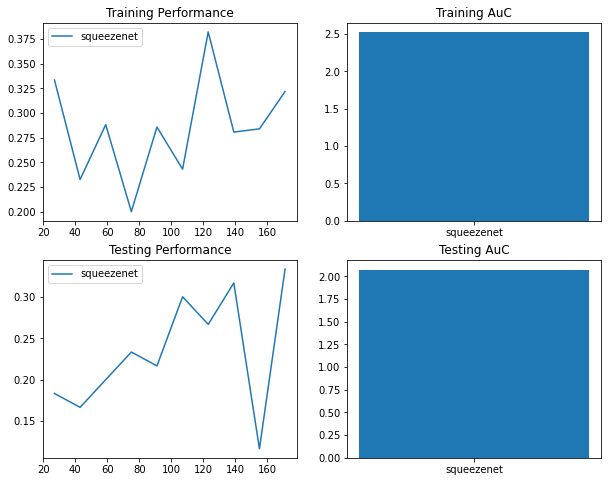

In [11]:
tester.plot_results()